# Implementing classification models to predict churn

## Loading data

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [45]:
X_train = pd.read_csv('../data/x_train.csv', encoding='utf-8')
X_test = pd.read_csv('../data/x_test.csv', encoding='utf-8')

y_train = pd.read_csv('../data/y_train.csv', encoding='utf-8')
y_test = pd.read_csv('../data/y_test.csv', encoding='utf-8')

In [46]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tenure            5634 non-null   int64  
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   int64  
 3   Partner           5634 non-null   object 
 4   Dependents        5634 non-null   object 
 5   PhoneService      5634 non-null   object 
 6   MultipleLines     5634 non-null   object 
 7   InternetService   5634 non-null   object 
 8   OnlineSecurity    5634 non-null   object 
 9   OnlineBackup      5634 non-null   object 
 10  DeviceProtection  5634 non-null   object 
 11  TechSupport       5634 non-null   object 
 12  StreamingTV       5634 non-null   object 
 13  StreamingMovies   5634 non-null   object 
 14  Contract          5634 non-null   object 
 15  PaperlessBilling  5634 non-null   object 
 16  PaymentMethod     5634 non-null   object 


In [47]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1409 entries, 0 to 1408
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tenure            1409 non-null   int64  
 1   gender            1409 non-null   object 
 2   SeniorCitizen     1409 non-null   int64  
 3   Partner           1409 non-null   object 
 4   Dependents        1409 non-null   object 
 5   PhoneService      1409 non-null   object 
 6   MultipleLines     1409 non-null   object 
 7   InternetService   1409 non-null   object 
 8   OnlineSecurity    1409 non-null   object 
 9   OnlineBackup      1409 non-null   object 
 10  DeviceProtection  1409 non-null   object 
 11  TechSupport       1409 non-null   object 
 12  StreamingTV       1409 non-null   object 
 13  StreamingMovies   1409 non-null   object 
 14  Contract          1409 non-null   object 
 15  PaperlessBilling  1409 non-null   object 
 16  PaymentMethod     1409 non-null   object 


In [48]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Churn   5634 non-null   int64
dtypes: int64(1)
memory usage: 44.1 KB


In [49]:
y_train.value_counts()

Churn
1        2822
0        2812
dtype: int64

In [50]:
y_test.value_counts()

Churn
1        720
0        689
dtype: int64

## Preprocessing pipeline

In [51]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder #, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# from sklearn.base import BaseEstimator, TransformerMixin

In [52]:
# Dividing variables into groups
target = 'Churn'
numerical_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_vars = [i for i in X_train.columns if i not in numerical_vars]

In [53]:
# pipelines for numerical and categorical variables
numerical_pipe = Pipeline(steps=[
    ('scaling', RobustScaler())
])

categorical_pipe = Pipeline(steps=[
    #('categorical_transform', CategoricalTransformer(category_dict=category_dict, columns=categorical_vars)),
    ('encoding', OneHotEncoder(handle_unknown='ignore'))
])

In [132]:
# transformador para dividir procesos de vars numéricas y categóricas
preprocessor = ColumnTransformer(transformers=[
    ('numerical', numerical_pipe, numerical_vars),
    ('categorical', categorical_pipe, categorical_vars)
])

The 'preprocessor' pipeline will help us preprocess numerical and categorical variables, treating each kind differently. Now, we define a general pipeline which will implement the 'preprocessor' and the model training together.

## Defining general pipeline

In [133]:
# models to try
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# useful tools
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc,confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif

In [135]:
general_pipe = Pipeline([
    ('preprocessor', preprocessor),
    #('dense', FunctionTransformer(make_dense, accept_sparse=True)),
    ('selector', SelectKBest(score_func=f_classif, k=7)),
    ('classifier', 'passthrough')
])

## Training the model

In [136]:
# possible hyperparameters for the models
param_grid = [
    {
        'classifier': [LogisticRegression()],
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 8, 10],
        'classifier__metric': ['cityblock', 'cosine', 'euclidean', 'manhattan'],
        'classifier__weights': ['uniform', 'distance']
    },
    {
        'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10, 100, 1000],
        'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001]
    },
    {
        'classifier': [GaussianNB()],
        'classifier__var_smoothing': np.logspace(0, -9, num=5)
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__max_depth':[3,5,10,None],
        'classifier__n_estimators':[10,100,200],
        'classifier__max_features':[1,3,5,7, None],
        'classifier__min_samples_leaf':[1,2,3],
        'classifier__min_samples_split':[1,2,3]
    }
]

In [137]:
# defining the searching grid
general_grid = GridSearchCV(estimator=general_pipe, param_grid=param_grid, cv=4, scoring='roc_auc', n_jobs=-1)

In [138]:
general_grid.fit(X_train, y_train)

/home/esnavarrete/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/esnavarrete/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/esnavarrete/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/esnavarrete/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('scaling',
                                                                                          RobustScaler())]),
                                                                         ['tenure',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('encoding',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'Multip...
                          'classifier__var_smoothing': array([1.00000000e+00, 5.62341325e-03, 3.16227766e-05, 1.77827941e-07,
       1.00000000e-09])},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__max_depth': [3, 5, 10, None],
                          'classifier__max_features': [1, 3, 5, 7, None],
                          'classifier__min_samples_leaf': [1, 2, 3],
                          'classifier__min_samples_split': [1, 2, 3],
                          'classifier__n_estimators': [10, 100, 200]}],
             scoring='roc_auc')

In [139]:
general_grid.best_score_

0.6744628431516961

In [140]:
general_grid.best_params_

{'classifier': LogisticRegression(), 'classifier__C': 1000}

In [141]:
results_summary = pd.DataFrame(general_grid.cv_results_)
results_summary.to_csv('../data/results_summary.csv', index=False)

In [142]:
results_summary['param_classifier'] = results_summary['param_classifier'].astype(str)

In [146]:
results_summary.groupby('param_classifier').agg({'mean_test_score':'max'}).sort_values(by='mean_test_score', ascending=False)\
.rename(columns={'param_classifier': 'Model', 'mean_test_score':'Performance'})

,Performance
param_classifier,
LogisticRegression(),0.674463
RandomForestClassifier(),0.674110
SVC(),0.672777
GaussianNB(),0.672142
KNeighborsClassifier(),0.637354


In [147]:
general_grid.best_estimator_.named_steps['classifier'].coef_

array([[-0.62454517,  0.48268401,  0.23651387,  0.22771614,  0.27698046,
         0.19603515,  0.2683923 ]])

In [145]:
general_grid.best_estimator_.named_steps

{'preprocessor': ColumnTransformer(transformers=[('numerical',
                                  Pipeline(steps=[('scaling', RobustScaler())]),
                                  ['tenure', 'MonthlyCharges', 'TotalCharges']),
                                 ('categorical',
                                  Pipeline(steps=[('encoding',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['gender', 'SeniorCitizen', 'Partner',
                                   'Dependents', 'PhoneService', 'MultipleLines',
                                   'InternetService', 'OnlineSecurity',
                                   'OnlineBackup', 'DeviceProtection',
                                   'TechSupport', 'StreamingTV',
                                   'StreamingMovies', 'Contract',
                                   'PaperlessBilling', 'PaymentMethod'])]),
 'selector': SelectKBest(k=7),
 'classifier': LogisticRegression

In [149]:
# Checking which variables correspond to each coefficient
selector = general_grid.best_estimator_.named_steps['selector']
encoded_feature_names = general_grid.best_estimator_.named_steps['preprocessor'].named_transformers_['categorical'].get_feature_names_out()
all_feature_names = np.concatenate([numerical_vars, encoded_feature_names])

# Get the support mask from SelectKBest
support_mask = selector.get_support()

# Get the selected feature names
selected_features = all_feature_names[support_mask]
list(selected_features)

['tenure',
 'InternetService_Fiber optic',
 'OnlineSecurity_No',
 'TechSupport_No',
 'Contract_Month-to-month',
 'Contract_Two year',
 'PaymentMethod_Electronic check']

## Prediction over test set

In [63]:
y_pred_best = general_grid.predict(X_test)

In [98]:
# ROC AUC score
roc_auc_score(y_true=y_test, y_score=y_pred_best)

0.6339733510724076

In [68]:
confusion_matrix(y_true=y_test, y_pred=y_pred_best)

array([[465, 224],
       [293, 427]])

In [69]:
print(classification_report(y_true=y_test, y_pred=y_pred_best))

              precision    recall  f1-score   support

           0       0.61      0.67      0.64       689
           1       0.66      0.59      0.62       720

    accuracy                           0.63      1409
   macro avg       0.63      0.63      0.63      1409
weighted avg       0.64      0.63      0.63      1409



In [90]:
# Plotting ROC curve
y_prob = general_grid.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)

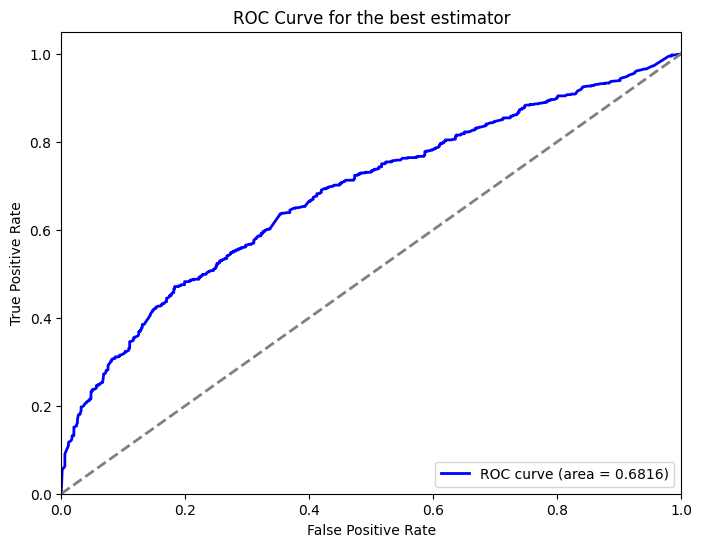

In [100]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc(fpr, tpr):.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for the best estimator')
plt.legend(loc="lower right")
plt.show()